# SETTING UP THE ENVIRONMENT

In [ ]:
!pip install lingam
!pip install graphviz

In [ ]:
import pandas as pd
from statsmodels.tsa.api import VAR
from lingam import DirectLiNGAM, VARLiNGAM
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from IPython.display import display, Image
from ipywidgets import FileUpload
from lingam.utils import make_dot, print_causal_directions, print_dagc
from graphviz import Digraph
from scipy.stats import pearsonr
from sklearn.preprocessing import StandardScaler
import plotly.graph_objects as go
import yfinance as yf
import plotly.express as px
import plotly.io as pio
import plotly.express as px
import plotly.graph_objects as go
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import plotly.express as px
import scipy.stats as stats
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt

# USEFUL FUNCTIONS

In [ ]:
def get_stock_data(start_date, end_date, interval='1d'):
    """
    Retrieves stock market data for a list of stocks with a specified time interval.

    Parameters:
    - start_date: Start date (in the format 'YYYY-MM-DD')
    - end_date: End date (in the format 'YYYY-MM-DD')
    - interval: Time interval ('1m', '2m', '5m', '15m', '30m', '1h', '1d', '1wk', '1mo')

    Returns:
    - Combined DataFrame containing the stock data.
    """
    import yfinance as yf

    tickers = {
        'Apple': 'AAPL',
        'Google': 'GOOGL',
        'Microsoft': 'MSFT',
        'Amazon': 'AMZN',
    }

    stock_data = {}

    for name, ticker in tickers.items():
        stock = yf.Ticker(ticker)
        data = stock.history(start=start_date, end=end_date, interval=interval)

        stock_data[f'Open_{name}'] = data['Open']
        stock_data[f'High_{name}'] = data['High']
        stock_data[f'Low_{name}'] = data['Low']
        stock_data[f'Close_{name}'] = data['Close']
        stock_data[f'Volume_{name}'] = data['Volume']

    combined_data = pd.DataFrame(stock_data)
    combined_data['Date'] = data.index
    return combined_data

In [ ]:
def describe_variables(df):
    """
    Provides a summary of the variables in a DataFrame, including descriptions, types, and units.

    Parameters:
    - df : pandas.DataFrame
        The DataFrame containing stock market data to describe.

    Returns:
    - pandas.DataFrame
        A DataFrame summarizing the variables in the input DataFrame with the following columns:
        - "Variable": Name of the variable (column name in the input DataFrame).
        - "Description": A brief description of the variable.
        - "Type": Data type of the variable (e.g., int64, float64, etc.).
        - "Unit": The unit of the variable (e.g., "Dollars" for prices, "Transactions" for volume, or "-" if not applicable).
    """
    descriptions = {
        "Open_Apple": "Opening price of Apple stocks",
        "High_Apple": "Maximum price of Apple stocks",
        "Low_Apple": "Minimum price of Apple stocks",
        "Close_Apple": "Closing price of Apple stocks",
        "Volume_Apple": "Transaction volume for Apple",
        "Open_Google": "Opening price of Google stocks",
        "High_Google": "Maximum price of Google stocks",
        "Low_Google": "Minimum price of Google stocks",
        "Close_Google": "Closing price of Google stocks",
        "Volume_Google": "Transaction volume for Google",
        "Open_Microsoft": "Opening price of Microsoft stocks",
        "High_Microsoft": "Maximum price of Microsoft stocks",
        "Low_Microsoft": "Minimum price of Microsoft stocks",
        "Close_Microsoft": "Closing price of Microsoft stocks",
        "Volume_Microsoft": "Transaction volume for Microsoft",
        "Open_Amazon": "Opening price of Amazon stocks",
        "High_Amazon": "Maximum price of Amazon stocks",
        "Low_Amazon": "Minimum price of Amazon stocks",
        "Close_Amazon": "Closing price of Amazon stocks",
        "Volume_Amazon": "Transaction volume for Amazon",
    }

    variables_summary = pd.DataFrame({
        "Variable": df.columns,
        "Description": [descriptions.get(col, "Description unavailable") for col in df.columns],
        "Type": [df[col].dtype for col in df.columns],
        "Unit": ["Dollars" if "Open" in col or "High" in col or "Low" in col or "Close" in col else "Transactions" if "Volume" in col else "-" for col in df.columns],
    })

    return variables_summary

In [ ]:
def plot_time_series(dataset):
    """
    Plots the columns of a DataFrame against the 'Date' column,
    excluding columns that contain 'Volume'.

    Args:
        dataset (pd.DataFrame): DataFrame containing the data and a 'Date' column.
    """
    if 'Date' not in dataset.columns:
        raise ValueError("The DataFrame must contain a 'Date' column.")

    fig = go.Figure()

    for column in dataset.columns:
        if column != 'Date' and 'Volume' not in column:
            fig.add_trace(go.Scatter(
                x=dataset['Date'],
                y=dataset[column],
                mode='lines',
                name=column
            ))

    fig.update_layout(
        title="Time Series of Stock Data",
        xaxis_title="Date",
        yaxis_title="Value",
        legend=dict(orientation="h", x=0, y=1.1),
        template="plotly_white",
        autosize=True
    )

    fig.show()

In [ ]:
def plot_adjacency_matrix(matrix, variable_names, title):
    """
    Plots an adjacency matrix using Matplotlib with labeled axes and a color bar.

    Parameters:
    - matrix : array-like
        The adjacency matrix to be plotted (2D array or DataFrame).
    - variable_names : list of str
        List of variable names corresponding to the rows and columns of the matrix.
    - title : str
        The title of the plot.

    Returns:
    - None
        Displays the adjacency matrix as a heatmap with causes on the x-axis and effects on the y-axis.
    """
    plt.figure(figsize=(10, 8))
    plt.imshow(matrix, cmap="viridis", aspect="auto")
    plt.colorbar(label="Weight")

    plt.xticks(range(len(variable_names)), variable_names, rotation=45, ha="right")
    plt.yticks(range(len(variable_names)), variable_names)

    plt.title(title)
    plt.xlabel("Cause (Columns)")
    plt.ylabel("Effect (Rows)")
    plt.tight_layout()
    plt.show()

In [ ]:
def plot_residuals_histograms_with_density(residuals, variable_names, selected_variables):
    """
    Plots histograms of residuals along with their normal density curves for selected variables.

    Parameters:
    - residuals : np.ndarray
        The residuals matrix of shape (n_samples, n_variables).
    - variable_names : list of str
        Names of the variables corresponding to the columns of the residuals matrix.
    - selected_variables : list of str
        Names of the variables to include in the plot.

    Returns:
    - None
        Displays an interactive Plotly figure with histograms and normal density curves.
    """
    selected_indices = [variable_names.index(var) for var in selected_variables]

    fig = go.Figure()

    for idx, var_index in enumerate(selected_indices):
        res = residuals[:, var_index]
        mean, std_dev = np.mean(res), np.std(res)

        hist_values, bin_edges = np.histogram(res, bins=30, density=True)

        fig.add_trace(go.Bar(
            x=bin_edges[:-1],
            y=hist_values,
            name=f'Histogram {selected_variables[idx]}',
            marker=dict(color='skyblue'),
            opacity=0.6
        ))

        x = np.linspace(bin_edges[0], bin_edges[-1], 100)
        p = stats.norm.pdf(x, mean, std_dev)

        fig.add_trace(go.Scatter(
            x=x,
            y=p,
            mode='lines',
            name=f'Normal Density {selected_variables[idx]}',
            line=dict(color='red', width=2)
        ))

    fig.update_layout(
        title='Residuals Histograms and Normal Density Curves',
        xaxis_title='Residuals',
        yaxis_title='Density',
        barmode='overlay',
        template='plotly_white',
        legend=dict(
            orientation="h",
            yanchor="bottom",
            y=1.02,
            xanchor="right",
            x=1
        )
    )

    fig.show()

In [ ]:
def test_residuals_normality(residuals, variable_names, variables_to_test):
    """
    Tests the normality of residuals for selected variables and displays the results in a Plotly table.

    Parameters:
    - residuals : np.ndarray
        The residuals matrix of shape (n_samples, n_variables).
    - variable_names : list of str
        Names of the variables corresponding to the columns of the residuals matrix.
    - variables_to_test : list of str
        Names of the variables to perform the normality tests on.

    Returns:
    - None
        Displays an interactive Plotly table with the results of the Shapiro-Wilk and Kolmogorov-Smirnov tests.
    """
    residuals_df = pd.DataFrame(residuals, columns=variable_names)
    selected_residuals = residuals_df[variables_to_test]

    results = []
    for variable in variables_to_test:
        data = selected_residuals[variable]

        shapiro_stat, shapiro_p = stats.shapiro(data)
        ks_stat, ks_p = stats.kstest(data, 'norm', args=(data.mean(), data.std()))

        results.append({
            "Variable": variable,
            "Shapiro-Wilk Statistic": f"{shapiro_stat:.4f}",
            "Shapiro-Wilk p-value": f"{shapiro_p:.4f}",
            "Kolmogorov-Smirnov Statistic": f"{ks_stat:.4f}",
            "Kolmogorov-Smirnov p-value": f"{ks_p:.4f}"
        })

    results_df = pd.DataFrame(results)

    fig = go.Figure(data=[go.Table(
        header=dict(
            values=list(results_df.columns),
            fill_color='lightgrey',
            align='center',
            font=dict(size=12, color='black'),
        ),
        cells=dict(
            values=[results_df[col] for col in results_df.columns],
            fill_color='white',
            align='center',
            font=dict(size=12, color='black'),
        )
    )])

    fig.update_layout(title_text="Normality Test Results", title_x=0.5)
    fig.show()

# DATASET AND VARIABLES

In [ ]:
tickers = {
    'Apple': 'AAPL',
    'Google': 'GOOGL',
    'Microsoft': 'MSFT',
    'Amazon': 'AMZN',
}

earliest_dates = {}
for name, ticker in tickers.items():
    stock = yf.Ticker(ticker)
    earliest_dates[name] = stock.history(period="max").index.min()
print("The earliest available date for stock data for a list of specified companies:")
for name, date in earliest_dates.items():
    print(f"{name}: {date}")

The earliest available date for stock data for a list of specified companies:
Apple: 1980-12-12 00:00:00-05:00
Google: 2004-08-19 00:00:00-04:00
Microsoft: 1986-03-13 00:00:00-05:00
Amazon: 1997-05-15 00:00:00-04:00


In [ ]:
start_date = "2010-01-01"
end_date = "2023-12-31"

dataset = get_stock_data(start_date, end_date, interval="1d")

dataset['Date'] = pd.to_datetime(dataset['Date'])

In [ ]:
data = dataset.drop(columns=['Date'])
variables_table = describe_variables(data)

fig = go.Figure(
    data=[
        go.Table(
            header=dict(
                values=["<b>Variable</b>", "<b>Description</b>", "<b>Type</b>", "<b>Unit</b>"],
                fill_color="lightblue",
                align="left",
                font=dict(size=12, color="black"),
            ),
            cells=dict(
                values=[
                    variables_table["Variable"],
                    variables_table["Description"],
                    variables_table["Type"].astype(str),
                    variables_table["Unit"],
                ],
                fill_color="white",
                align="left",
                font=dict(size=11),
            ),
        )
    ]
)

fig.update_layout(title="Description of Variables", title_font_size=16)
fig.show()

In [ ]:
fig = go.Figure(data=[
    go.Table(
        header=dict(
            values=list(dataset.columns),
            fill_color='paleturquoise',
            align='left'
        ),
        cells=dict(
            values=[dataset[col] for col in dataset.columns],
            fill_color='lavender',
            align='left'
        )
    )
])

fig.update_layout(title="Stock Chart")

fig.show()

In [ ]:
plot_time_series(dataset)

In [ ]:
print("Missing values :\n", dataset.isnull().sum())

Missing values :
 Open_Apple          0
High_Apple          0
Low_Apple           0
Close_Apple         0
Volume_Apple        0
Open_Google         0
High_Google         0
Low_Google          0
Close_Google        0
Volume_Google       0
Open_Microsoft      0
High_Microsoft      0
Low_Microsoft       0
Close_Microsoft     0
Volume_Microsoft    0
Open_Amazon         0
High_Amazon         0
Low_Amazon          0
Close_Amazon        0
Volume_Amazon       0
Date                0
dtype: int64


In [ ]:
correlation_matrix = dataset.corr(method='spearman')
fig = go.Figure(data=go.Heatmap(
    z=correlation_matrix.values,
    x=correlation_matrix.columns,
    y=correlation_matrix.columns,
    colorscale="RdYlGn",
    colorbar=dict(title="Spearman Correlation"),
    zmin=-1,
    zmax=1
))
fig.update_layout(
    title="Spearman Correlation Heatmap",
    xaxis_title="Features",
    yaxis_title="Features",
    xaxis=dict(tickangle=45),
    yaxis=dict(tickangle=0),
    width=800,
    height=800,
    template="plotly_white"
)
fig.show()

# CAUSAL ANALYSIS : VAR-LiNGAM

## Data Normalization

In [ ]:
start_date = "2010-01-01"
end_date = "2023-12-31"
dataset = get_stock_data(start_date, end_date, interval="1d")
display(dataset)

Open_Apple  High_Apple   Low_Apple  Close_Apple  \
Date                                                                         
2010-01-04 00:00:00-05:00    6.429939    6.462175    6.398307     6.447413   
2010-01-05 00:00:00-05:00    6.465188    6.495013    6.424516     6.458560   
2010-01-06 00:00:00-05:00    6.458560    6.484168    6.349200     6.355828   
2010-01-07 00:00:00-05:00    6.379328    6.386860    6.297985     6.344079   
2010-01-08 00:00:00-05:00    6.335642    6.386857    6.298285     6.386254   
...                               ...         ...         ...          ...   
2023-12-22 00:00:00-05:00  194.228473  194.457363  192.029255   192.656189   
2023-12-26 00:00:00-05:00  192.666139  192.944773  191.889943   192.108871   
2023-12-27 00:00:00-05:00  191.551588  192.556659  190.158404   192.208359   
2023-12-28 00:00:00-05:00  193.193528  193.710998  192.228256   192.636261   
2023-12-29 00:00:00-05:00  192.954701  193.452263  190.795282   191.591385   

                           Volume_Apple  Open_Google  High_Google  Low_Google  \
Date                                                                            
2010-01-04 00:00:00-05:00     493729600    15.632769    15.696602   15.565197   
2010-01-05 00:00:00-05:00     601904800    15.638505    15.654962   15.497874   
2010-01-06 00:00:00-05:00     552160000    15.605590    15.605590   15.119365   
2010-01-07 00:00:00-05:00     477131200    15.195166    15.210128   14.777512   
2010-01-08 00:00:00-05:00     447610800    14.761304    15.041818   14.689242   
...                                 ...          ...          ...         ...   
2023-12-22 00:00:00-05:00      37122800   140.261542   141.477137  140.201761   
2023-12-26 00:00:00-05:00      28919300   141.078574   142.164633  140.680025   
2023-12-27 00:00:00-05:00      48087700   141.078571   141.566806  139.384714   
2023-12-28 00:00:00-05:00      34049900   140.271497   140.630197  139.245218   
2023-12-29 00:00:00-05:00      42628800   139.125659   139.853018  138.278723   

                           Close_Google  Volume_Google  ...  High_Microsoft  \
Date                                                    ...                   
2010-01-04 00:00:00-05:00     15.627782       78169752  ...       23.413613   
2010-01-05 00:00:00-05:00     15.558963      120067812  ...       23.413614   
2010-01-06 00:00:00-05:00     15.166740      158988852  ...       23.398554   
2010-01-07 00:00:00-05:00     14.813666      256315428  ...       23.112470   
2010-01-08 00:00:00-05:00     15.011149      188783028  ...       23.247984   
...                                 ...            ...  ...             ...   
2023-12-22 00:00:00-05:00    140.978943       26514600  ...      372.395266   
2023-12-26 00:00:00-05:00    141.008835       16780300  ...      374.142196   
2023-12-27 00:00:00-05:00    139.862976       19628600  ...      372.276160   
2023-12-28 00:00:00-05:00    139.723480       16045700  ...      373.665741   
2023-12-29 00:00:00-05:00    139.185440       18727200  ...      374.360553   

                           Low_Microsoft  Close_Microsoft  Volume_Microsoft  \
Date                                                                          
2010-01-04 00:00:00-05:00      23.029660        23.300686          38409100   
2010-01-05 00:00:00-05:00      23.067303        23.308214          49749600   
2010-01-06 00:00:00-05:00      22.976958        23.165171          58182400   
2010-01-07 00:00:00-05:00      22.728516        22.924257          50559700   
2010-01-08 00:00:00-05:00      22.766161        23.082357          51197400   
...                                  ...              ...               ...   
2023-12-22 00:00:00-05:00     369.943598       371.799713          17091100   
2023-12-26 00:00:00-05:00     370.727726       371.879120          12673100   
2023-12-27 00:00:00-05:00     370.042861       371.293518          14905400   
2023-12-28 00:00:00-05:00     371.382825       372.494507    

In [ ]:
scaler = StandardScaler()
dataset = pd.DataFrame(scaler.fit_transform(dataset.drop(columns=['Date'])), columns=dataset.drop(columns=['Date']).columns)
fig = go.Figure(data=[
    go.Table(
        header=dict(
            values=list(dataset.columns),
            fill_color='paleturquoise',
            align='left'
        ),
        cells=dict(
            values=[dataset[col] for col in dataset.columns],
            fill_color='lavender',
            align='left'
        )
    )
])

fig.update_layout(title="Normalized Stock Chart (Standardization : mean = 0, standard-deviation = 1)")

fig.show()

## VAR-LiNGAM Training

First of all, the model is initialized with several parameters. The lags=30 parameter indicates that we analyze temporal relationships up to 30 lags, i.e. the model takes into account the effect of 30 past observations for each variable in predictions and causal analysis. The criterion criterion='bic' means that the model will automatically select the best structure according to the Bayesian Information Criterion (BIC), which penalizes models that are too complex to favor parsimony. The prune=False option disables the mechanism for pruning weak causal links, which means that all relationships identified by the model will be retained, even those that are statistically less significant. The parameter ar_coefs=None means that autoregressive coefficients are not explicitly provided by the user, but will be learned directly from the data during model training. Finally, the random_state=42 argument sets the random seed to ensure reproducibility of results, which is important to guarantee that the results obtained are deterministic if the model is rerun.

In [ ]:
model = VARLiNGAM(lags=30, criterion='bic', prune=False, ar_coefs=None, random_state=42)
model.fit(dataset)

The variable adj_matrix_0 corresponds to the adjacency matrix for time lag 0 (present time). It indicates direct causal relationships between variables at the same instant, i.e. contemporary dependencies. For example, if a non-zero value is present at the intersection of row i and column j, this means that variable j directly influences variable i in the same time step.

The variable adj_matrix_1, on the other hand, corresponds to the adjacency matrix for time lag 1 (one time step in the past). It captures causal relationships between variables with a delay of one time unit. For example, a non-zero value at position (i, j) indicates that variable j at time t-1 has a direct causal effect on variable i at time t.

In [ ]:
adj_matrix_0 = model.adjacency_matrices_[0]
adj_matrix_1 = model.adjacency_matrices_[1]

### Adjency matrices

In [ ]:
variable_names = dataset.columns.tolist()

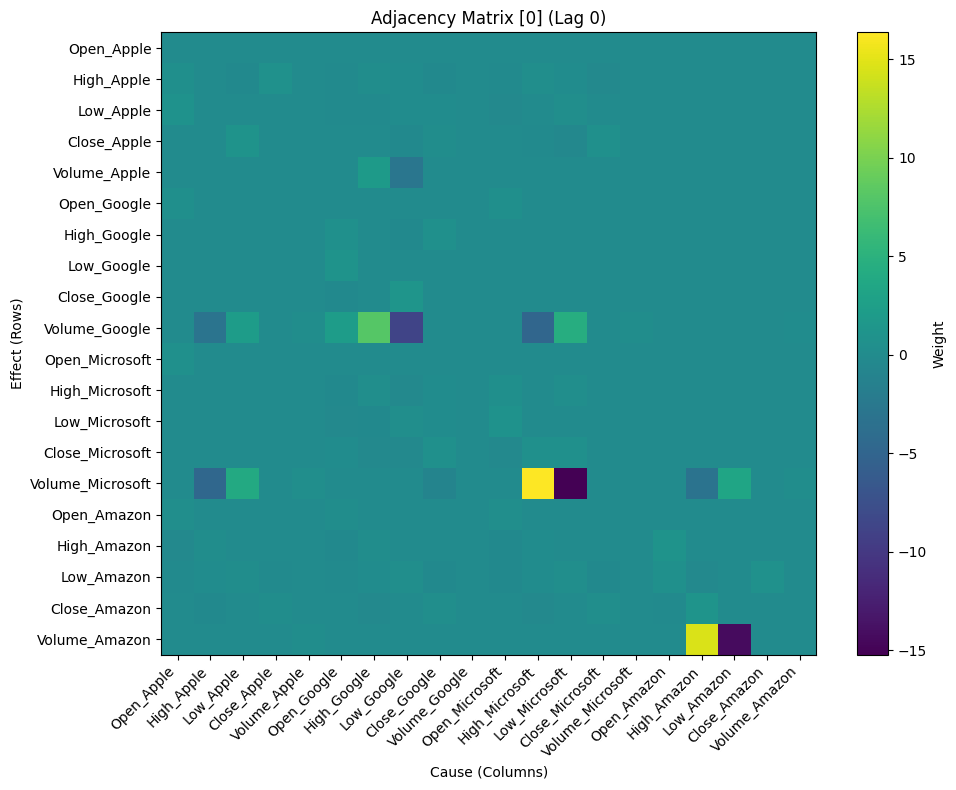

In [ ]:
plot_adjacency_matrix(adj_matrix_0, variable_names, "Adjacency Matrix [0] (Lag 0)")

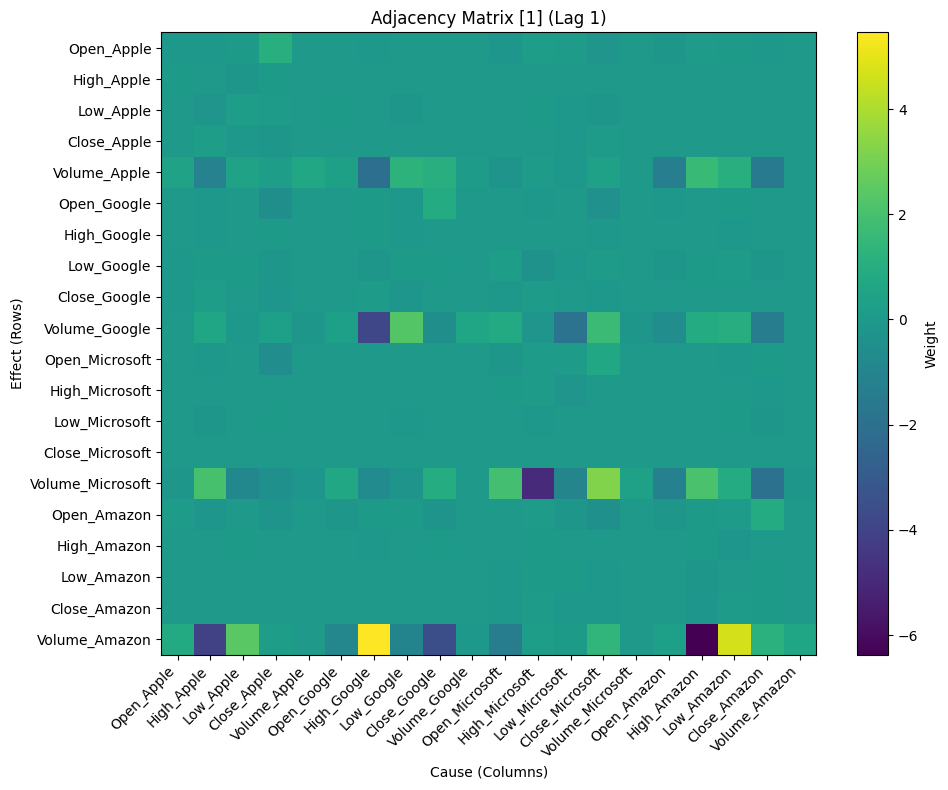

In [ ]:
plot_adjacency_matrix(adj_matrix_1, variable_names, "Adjacency Matrix [1] (Lag 1)")

In [ ]:
variables = [
    'Open_Apple', 'High_Apple', 'Low_Apple', 'Close_Apple', 'Volume_Apple',
    'Open_Google', 'High_Google', 'Low_Google', 'Close_Google', 'Volume_Google',
    'Open_Microsoft', 'High_Microsoft', 'Low_Microsoft', 'Close_Microsoft', 'Volume_Microsoft',
    'Open_Amazon', 'High_Amazon', 'Low_Amazon', 'Close_Amazon', 'Volume_Amazon'
]
lags = 1
labels = []
for lag in range(0, lags + 1):
    if lag == 0:
        labels.extend([f"{var}(t)" for var in variables])
    else:
        labels.extend([f"{var}(t-{lag})" for var in variables])
print(labels[:50])

['Open_Apple(t)', 'High_Apple(t)', 'Low_Apple(t)', 'Close_Apple(t)', 'Volume_Apple(t)', 'Open_Google(t)', 'High_Google(t)', 'Low_Google(t)', 'Close_Google(t)', 'Volume_Google(t)', 'Open_Microsoft(t)', 'High_Microsoft(t)', 'Low_Microsoft(t)', 'Close_Microsoft(t)', 'Volume_Microsoft(t)', 'Open_Amazon(t)', 'High_Amazon(t)', 'Low_Amazon(t)', 'Close_Amazon(t)', 'Volume_Amazon(t)', 'Open_Apple(t-1)', 'High_Apple(t-1)', 'Low_Apple(t-1)', 'Close_Apple(t-1)', 'Volume_Apple(t-1)', 'Open_Google(t-1)', 'High_Google(t-1)', 'Low_Google(t-1)', 'Close_Google(t-1)', 'Volume_Google(t-1)', 'Open_Microsoft(t-1)', 'High_Microsoft(t-1)', 'Low_Microsoft(t-1)', 'Close_Microsoft(t-1)', 'Volume_Microsoft(t-1)', 'Open_Amazon(t-1)', 'High_Amazon(t-1)', 'Low_Amazon(t-1)', 'Close_Amazon(t-1)', 'Volume_Amazon(t-1)']


### Causal Graph

The causal graph derived from VAR-LiNGAM is a directed, weighted representation of causal relationships between variables. Each node in the graph represents a variable, and an arrow pointing from node A to node B indicates that A has a causal effect on B. The weights associated with the edges, indicated by the adjacency matrix, quantify the strength of the causal effect.

In the VARLiNGAM model, the causal graph includes two types of relationships. Contemporary relationships, corresponding to a time lag of 0, are represented by the coefficients of the adjacency matrix at the present time. These relationships indicate simultaneous interactions, where one variable exerts a direct causal effect on another at the same instant. Delayed relationships, on the other hand, come from adjacency matrices associated with time lags greater than 0 (e.g. t-1,t-2, etc.). An arrow in the graph, starting from a node representing a variable A at an earlier point in time and heading towards a node representing a variable B at a later point in time, illustrates the delayed causal influence of A on B. These two types of relationships capture both immediate dependencies and delayed interactions between variables in temporal data.

In [ ]:
adjacency_matrices = np.hstack(model.adjacency_matrices_)
graph = make_dot(adjacency_matrices, ignore_shape=True, lower_limit=0.1, labels=labels)
graph.view()

'Digraph.gv.pdf'

### Causal graph with focus on Google_Close

In [ ]:
close_google_index = labels.index("Close_Google(t)")
filtered_adjacency = adjacency_matrices[close_google_index, :]
filtered_adjacency_in = adjacency_matrices[:, close_google_index]

final_adjacency = np.zeros_like(adjacency_matrices)
final_adjacency[close_google_index, :] = filtered_adjacency
final_adjacency[:, close_google_index] = filtered_adjacency_in
graph = make_dot(final_adjacency, ignore_shape=True, lower_limit=0.1, labels=labels)

graph.view()

'Digraph.gv.pdf'

### Residuals (Validation of the non-Gaussianity hypothesis)

When a VARLiNGAM model is fitted, it estimates the causal relationships between variables, both contemporaneous (present moment) and delayed (time lags). These relationships are modeled in the form of linear equations. The residuals are then the differences between the observed values of the variables and the values predicted by these equations.

In [ ]:
residuals = model.residuals_

In [ ]:
selected_variables = ['High_Apple', 'Close_Apple', 'High_Google', 'Low_Google', 'High_Microsoft']

In [ ]:
plot_residuals_histograms_with_density(residuals=residuals, variable_names=variable_names, selected_variables=selected_variables)

The normality test examines whether the residuals for each specified variable follow a normal distribution. In the context of VARLiNGAM, the non-Gaussianity of residuals is a key assumption, as it enables the model to identify causal relationships between variables. A normal distribution of residuals could indicate that the model is misspecified or that certain causal relationships have not been correctly identified. So, after superimposing the distribution of residuals on the normal distribution, we check the validity of the hypothesis with two statistical calculations of standard normality:
- Shapiro-Wilk test
- Kolmogorov-Smirnov test

In [ ]:
test_residuals_normality(residuals=model.residuals_, variable_names=variable_names, variables_to_test=["High_Apple", "Close_Apple", "High_Google", "Low_Google", "High_Microsoft"])

# TRAINING THE FORECAST MODEL

## TRAINING THE FORECAST MODEL WITH CAUSAL DISCOVERY

### Training

In this section, we attempt to predict the closing price of Google shares using neural networks based on LSTM (Long Short-Term Memory), a recurrent network architecture adapted to time series.

We create new columns to use the features selected using VAR-LiNGAM, such as High_Apple(t-1) and Close_Apple(t-1), by shifting the values of the original columns by one time step (t-1). This operation makes it possible to incorporate historical data as predictor variables in the model.

The create_sequences function is defined to transform scalar data into temporal sequences. Each sequence contains consecutive observations over a given period (by default, a time step). This structure is essential for feeding the LSTM, which exploits the temporal dependency between these observations.

The resulting sequential data is divided into training and test sets in a ratio of 80% training and 20% test. The shuffle=False parameter ensures that the data remain in their temporal order, which is crucial for time series.

Le modèle est ensuite construit en utilisant une architecture LSTM. Une couche LSTM composée de 50 neurones est ajoutée, avec le paramètre return_sequences=False, indiquant qu’elle ne retourne que la dernière sortie de la séquence. Une régularisation via un Dropout de 0.2 est appliquée pour éviter le surapprentissage en désactivant aléatoirement 20 % des neurones pendant l’entraînement. Enfin, une couche dense avec une seule unité est ajoutée pour produire la prédiction.

Le modèle est compilé en utilisant l'optimiseur Adam et l’erreur quadratique moyenne MSE comme fonction de perte. L'entraînement est réalisé sur 50 époques avec une taille de lot de 32, et les performances du modèle sont évaluées sur un ensemble de validation. La sortie enregistre les métriques à chaque époque pour analyser la convergence du modèle.

In [ ]:
start_date = "2010-01-01"
end_date = "2023-12-31"
dataset = get_stock_data(start_date, end_date, interval="1d")

dataset['High_Apple(t-1)'] = dataset['High_Apple'].shift(1)
dataset['Close_Apple(t-1)'] = dataset['Close_Apple'].shift(1)
dataset['High_Google(t-1)'] = dataset['High_Google'].shift(1)
dataset['Low_Google(t-1)'] = dataset['Low_Google'].shift(1)
dataset['High_Microsoft(t-1)'] = dataset['High_Microsoft'].shift(1)

dataset = dataset.dropna()

features = [
    'High_Apple(t-1)', 'Close_Apple(t-1)',
    'High_Google(t-1)', 'Low_Google(t-1)',
    'High_Microsoft(t-1)'
]
target = 'Close_Google'

X = dataset[features]
y = dataset[target]

scaler_X = MinMaxScaler(feature_range=(0, 1))
scaler_y = MinMaxScaler(feature_range=(0, 1))

X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1))

def create_sequences(X, y, time_steps=1):
    X_seq, y_seq = [], []
    for i in range(len(X) - time_steps):
        X_seq.append(X[i:i + time_steps])
        y_seq.append(y[i + time_steps])
    return np.array(X_seq), np.array(y_seq)

time_steps = 1
X_seq, y_seq = create_sequences(X_scaled, y_scaled, time_steps)

X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.2, random_state=42, shuffle=False)

# ----------- LSTM -----------

model = Sequential()
model.add(LSTM(50, return_sequences=False, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')

history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_test, y_test),
    verbose=1)

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



88/88 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0231 - val_loss: 0.0121
Epoch 2/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0018 - val_loss: 0.0046
Epoch 3/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0012 - val_loss: 0.0026
Epoch 4/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9.5265e-04 - val_loss: 0.0018
Epoch 5/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8.2524e-04 - val_loss: 0.0013
Epoch 6/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 6.7095e-04 - val_loss: 0.0015
Epoch 7/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.6143e-04 - val_loss: 0.0015
Epoch 8/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5.0771e-04 - val_loss: 0.0026
Epoch 9/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.6961e-04 - val_loss: 0.0014
Epoch 10/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.1428e-04 - val_loss: 0.0018
Epoch 11/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.9414e-04 - val_loss: 0.0023
Epoch 12/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - 

### Selected features

In [ ]:
fig = go.Figure()

for feature in X.columns:
    fig.add_trace(go.Scatter(
        x=dataset.index,
        y=X[feature],
        mode='lines',
        name=feature
    ))

fig.update_layout(title='Time Series of Features', xaxis_title='Date', yaxis_title='Prices', legend=dict(orientation="h", yanchor="bottom",
        y=1.02,
        xanchor="right",
        x=1)
)
fig.show()

### Results

In [ ]:
y_pred = model.predict(X_test)

y_pred_rescaled = scaler_y.inverse_transform(y_pred)
y_test_rescaled = scaler_y.inverse_transform(y_test)

rmse = np.sqrt(mean_squared_error(y_test_rescaled, y_pred_rescaled))
print(f"RMSE : {rmse}")
fig = go.Figure()
fig.add_trace(go.Scatter(
    y=y_test_rescaled.flatten(),
    mode='lines',
    name='Actual values',
    line=dict(color='blue')
))

fig.add_trace(go.Scatter(
    y=y_pred_rescaled.flatten(),
    mode='lines',
    name='Forecast',
    line=dict(color='red')
))

fig.update_layout(
    title='Close_Google forecast',
    xaxis_title='Index',
    yaxis_title='Price',
    legend=dict(
        orientation="h",
        yanchor="bottom",
        y=1.02,
        xanchor="right",
        x=1
    )
)
fig.show()

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
RMSE : 4.516050015090525


## TRAINING THE FORECAST MODEL WITHOUT CAUSAL DISCOVERY

### Training

In [ ]:
start_date = "2010-01-01"
end_date = "2023-12-31"

dataset = get_stock_data(start_date, end_date, interval="1d")

dataset['Low_Apple(t-1)'] = dataset['Low_Apple'].shift(1)
dataset['Open_Microsoft(t-1)'] = dataset['Open_Microsoft'].shift(1)
dataset['Open_Amazon(t-1)'] = dataset['Open_Amazon'].shift(1)
dataset['High_Amazon(t-1)'] = dataset['High_Amazon'].shift(1)
dataset['Low_Microsoft(t-1)'] = dataset['Low_Microsoft'].shift(1)

dataset = dataset.dropna()

features = [
    'Low_Apple(t-1)', 'Open_Microsoft(t-1)',
    'Open_Amazon(t-1)', 'High_Amazon(t-1)',
    'Low_Microsoft(t-1)'
]
target = 'Close_Google'

X = dataset[features]
y = dataset[target]

scaler_X = MinMaxScaler(feature_range=(0, 1))
scaler_y = MinMaxScaler(feature_range=(0, 1))

X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1))

def create_sequences(X, y, time_steps=1):
    X_seq, y_seq = [], []
    for i in range(len(X) - time_steps):
        X_seq.append(X[i:i + time_steps])
        y_seq.append(y[i + time_steps])
    return np.array(X_seq), np.array(y_seq)

time_steps = 1
X_seq, y_seq = create_sequences(X_scaled, y_scaled, time_steps)

X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.2, random_state=42, shuffle=False)

model = Sequential()

model.add(LSTM(50, return_sequences=False, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))

model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_test, y_test),
    verbose=1
)

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



88/88 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.0364 - val_loss: 0.0405
Epoch 2/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0033 - val_loss: 0.0222
Epoch 3/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0027 - val_loss: 0.0211
Epoch 4/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0024 - val_loss: 0.0263
Epoch 5/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0022 - val_loss: 0.0371
Epoch 6/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0020 - val_loss: 0.0406
Epoch 7/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0017 - val_loss: 0.0483
Epoch 8/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0017 - val_loss: 0.0511
Epoch 9/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0015 - val_loss: 0.0639
Epoch 10/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0013 - val_loss: 0.0637
Epoch 11/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0013 - val_loss: 0.0578
Epoch 12/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0013 - val_loss: 0.0712


### Selected features

In [ ]:
fig = go.Figure()

for feature in X.columns:
    fig.add_trace(go.Scatter(
        x=dataset.index,
        y=X[feature],
        mode='lines',
        name=feature
    ))

fig.update_layout(title='Time Series of Features', xaxis_title='Date', yaxis_title='Prices', legend=dict(orientation="h", yanchor="bottom",
        y=1.02,
        xanchor="right",
        x=1)
)
fig.show()

### Results

In [ ]:
y_pred = model.predict(X_test)

y_pred_rescaled = scaler_y.inverse_transform(y_pred)
y_test_rescaled = scaler_y.inverse_transform(y_test)

rmse = np.sqrt(mean_squared_error(y_test_rescaled, y_pred_rescaled))
print(f"RMSE : {rmse}")
fig = go.Figure()
fig.add_trace(go.Scatter(
    y=y_test_rescaled.flatten(),
    mode='lines',
    name='Actual values',
    line=dict(color='blue')
))

fig.add_trace(go.Scatter(
    y=y_pred_rescaled.flatten(),
    mode='lines',
    name='Forecast',
    line=dict(color='red')
))

fig.update_layout(
    title='Close_Google forecast',
    xaxis_title='Index',
    yaxis_title='Price',
    legend=dict(
        orientation="h",
        yanchor="bottom",
        y=1.02,
        xanchor="right",
        x=1
    )
)
fig.show()

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
RMSE : 20.81193869078237
